<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_REINFORCE_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet box2d-py
import sys
import mxnet  
import gym
import numpy as np  
from mxnet import nd,autograd,init
from mxnet.gluon import nn,trainer
import matplotlib.pyplot as plt
from mxnet.gluon import Trainer

# PolicyNetwork

In [0]:
def build_policy(net,action_dim):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(action_dim))
  return net

# env

In [3]:
env_name = 'CartPole-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(state_dim,action_dim)

4 2


# initialize

In [0]:
max_episodes = 1000
max_steps = 1000
log_interval = 10
solved_score = 500
gamma = 0.99
lr = 0.001
policy_net = build_policy(nn.HybridSequential(),action_dim)
policy_net.hybridize()
policy_net.initialize(init=init.Xavier())
trainer = Trainer(policy_net.collect_params(),'adam',{'learning_rate':lr})

# main loop

0 11.0
10 20.2
20 19.0
30 23.9
40 19.1
50 26.6
60 34.6
70 35.6
80 49.4
90 53.8
100 56.7
110 110.7
120 143.2
130 186.5
140 176.4
150 256.4
160 273.0
170 347.2
180 436.9
190 319.4
200 411.2
210 412.4
220 450.9
230 425.0
240 436.3
249 500.0 500.0 solved


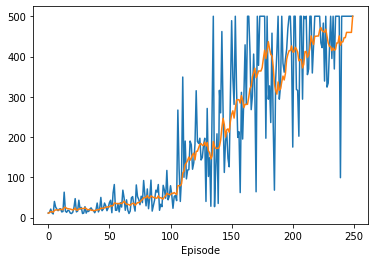

In [5]:
all_rewards = []
avg_all_rewards = []

for episode in range(max_episodes):
  
  state = env.reset()
  log_probs = []
  rewards = []
  
  with autograd.record():
    for time_step in range(max_steps):
      state = nd.array([state])
      
      probs = nd.softmax(policy_net(state))
      action,log_prob = nd.random.multinomial(probs,get_prob=True)
      state,reward,done,info = env.step(action.asnumpy()[0])
      
      log_probs.append(log_prob)
      rewards.append(reward)
      
      if done:
        break
    
    all_rewards.append(np.sum(rewards))
    avg_all_rewards.append(np.mean(all_rewards[-10:]))
    
    R = 0
    for i in range(len(rewards)-1, -1, -1):
      R = rewards[i] + gamma * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std()
    
    loss = []
    for log_prob,Gt in zip(log_probs,rewards):
      loss.append(log_prob*(-Gt))
  
  autograd.backward(loss)
  trainer.step(len(loss))
  
  if episode % log_interval == 0:
    print(episode,avg_all_rewards[-1])
  
  if (all_rewards[-1] >= solved_score)&(avg_all_rewards[-1] >= solved_score):
    print(episode,all_rewards[-1],avg_all_rewards[-1],'solved')
    break

plt.plot(all_rewards)
plt.plot(avg_all_rewards)
plt.xlabel('Episode')
plt.show()

In [0]:
policy_net.export('{}_model'.format(env_name))

In [0]:
del policy_net

In [8]:
deserialized_net = nn.SymbolBlock.imports("{}_model-symbol.json".format(env_name), 
                                          ['data'], 
                                          "{}_model-0000.params".format(env_name))

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [0]:
env = gym.make('CartPole-v1')
policy_net = deserialized_net

In [10]:
for episode in range(10):
  state = env.reset()
  rewards = []
  for time_step in range(1000):
    state = nd.array([state])
    probs = nd.softmax(policy_net(state))
    action = np.argmax(probs.asnumpy())
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
      break
  print(episode,np.sum(rewards))

0 500.0
1 500.0
2 500.0
3 500.0
4 500.0
5 500.0
6 500.0
7 500.0
8 500.0
9 500.0
